## Prophet (Modelo por Entidad)

Objetivo: Implementar un approach de "muchos modelos" (32) para pronosticar la serie de tiempo de cada Entidad de forma independiente. Las predicciones finales se agregarán para obtener una visión Nacional.

### 1. Configuración del Entorno (Librerías y Carga de Datos)

Se importan todas las librerías necesarias y se cargan los archivos v3 que usaremos:

- df_entidad: El DataFrame principal para entrenar los 32 modelos (contiene Entity y New_Cases).

- df_nacional: El DataFrame que usaremos al final para la evaluación nacional agregada.

In [43]:
# --- 1. Carga de Librerías ---

# Núcleo y Manipulación de Datos
import pandas as pd
import numpy as np
import time
import itertools

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from prophet import Prophet

# Evaluación y Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Ignorar advertencias para una salida limpia
import warnings
warnings.filterwarnings("ignore")

print("Librerías importadas exitosamente.")


# --- 2. Carga de Datos (Versión 3) ---
# Se cargan los archivos 'v3' relevantes.

print("\nCargando Datasets v3...")
path_total_entity = '../data/processed/data_processed_v3_NoAcum_Total.csv'
path_national = '../data/processed/data_processed_v3_National_NoAcum_Total.csv'

try:
    # El DataFrame principal que usaremos para ENTRENAR los 32 modelos
    df_entidad = pd.read_csv(path_total_entity)
    
    # El DataFrame que usaremos para la EVALUACIÓN NACIONAL al final
    df_eval_national = pd.read_csv(path_national)

    # Se convierte la columna 'Date' a datetime en ambos dataframes
    # pd.to_datetime reconocerá automáticamente el formato M/D/YYYY
    df_entidad['Date'] = pd.to_datetime(df_entidad['Date'])
    df_eval_national['Date'] = pd.to_datetime(df_eval_national['Date'])
    
    print("Datos cargados exitosamente.")
    print("\nInformación del DataFrame principal (Total por Entidad):")
    df_entidad.info()
    print(df_entidad.head())

except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar un archivo. Verifica la ruta: {e.filename}")

Librerías importadas exitosamente.

Cargando Datasets v3...
Datos cargados exitosamente.

Información del DataFrame principal (Total por Entidad):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Year       18304 non-null  int64         
 1   Week       18304 non-null  int64         
 2   Date       18304 non-null  datetime64[ns]
 3   Entity     18304 non-null  object        
 4   Epi_Year   18304 non-null  int64         
 5   New_Cases  18304 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 858.1+ KB
   Year  Week       Date          Entity  Epi_Year  New_Cases
0  2014     2 2014-01-06  Aguascalientes      2014        0.0
1  2014     3 2014-01-13  Aguascalientes      2014        0.0
2  2014     4 2014-01-20  Aguascalientes      2014        0.0
3  2014     5 2014-01-27  Aguascalient

### 2. Preparación del DataFrame Maestro (Formato Prophet)

Los datos ya están limpios y agregados. El único paso de preparación es renombrar las columnas al formato que Prophet requiere (ds para la fecha, y para el valor) y usar Entity como nuestro identificador para el bucle.

In [44]:
print("\n--- Paso 2: Preparando el DataFrame Maestro (Formato Prophet) ---")

# 1. Se renombran las columnas al formato requerido por Prophet
df_prophet_master = df_entidad.rename(columns={
    'Date': 'ds',
    'Entity': 'unique_id',      # Usaremos 'unique_id' para iterar sobre las 32 entidades
    'New_Cases': 'y'
})

# 2. Se asegura el orden cronológico
df_prophet_master = df_prophet_master.sort_values(by='ds')

print("\nDataFrame 'largo' creado exitosamente.")
print(f"Número total de series a modelar: {df_prophet_master['unique_id'].nunique()}")
print(df_prophet_master.head())


--- Paso 2: Preparando el DataFrame Maestro (Formato Prophet) ---

DataFrame 'largo' creado exitosamente.
Número total de series a modelar: 32
       Year  Week         ds       unique_id  Epi_Year    y
0      2014     2 2014-01-06  Aguascalientes      2014  0.0
16016  2014     2 2014-01-06        Tlaxcala      2014  0.0
15444  2014     2 2014-01-06      Tamaulipas      2014  0.0
14872  2014     2 2014-01-06         Tabasco      2014  0.0
14300  2014     2 2014-01-06          Sonora      2014  0.0


### 3. Definición de Parámetros de Modelado y Eventos

Se definen las constantes para el bucle de modelado. Esto incluye el horizonte de pronóstico (52 semanas), la rejilla de hiperparámetros (Grid Search) y el evento de la pandemia (con el impacto de 1.5 años).

In [46]:
print("\n--- Paso 3: Definiendo Parámetros del Modelo y Eventos ---")

# --- 1. Definición de Constantes del Modelo ---
HORIZONTE_PRONOSTICO = 52  # 52 semanas (un año)
TS_SPLITS = 3             # Número de folds para la validación cruzada (GridSearch)

# Se obtienen los 32 identificadores únicos de las entidades
grupos_unicos = df_prophet_master['unique_id'].unique()
print(f"Se modelarán {len(grupos_unicos)} series de tiempo (una por entidad).")

# --- 2. Definición de la Rejilla de Hiperparámetros (Grid Search) ---
# Se usa la rejilla que sabemos que es robusta
param_grid_prophet = {
    'seasonality_mode': ['additive', 'multiplicative'], # Bloqueamos 'multiplicative', que sabemos que es mejor
    'changepoint_prior_scale': [0.1, 0.5, 1.0],
    'n_changepoints': [25, 35],
    'holidays_prior_scale': [5.0, 10.0]
}
all_params = [dict(zip(param_grid_prophet.keys(), v)) for v in itertools.product(*param_grid_prophet.values())]
print(f"Se probarán {len(all_params)} combinaciones de hiperparámetros por cada serie.")

# --- 3. Definición de Eventos Especiales (Pandemia) ---
# Se define el período de impacto de 1.5 años (548 días)
pandemia_covid = pd.DataFrame({
  'holiday': 'pandemia_covid',
  'ds': pd.to_datetime(['2020-03-23']), # Fecha de inicio
  'lower_window': 0,                     # El impacto inicia el mismo día
  'upper_window': 548,                   # El impacto dura 1.5 años (548 días)
})
print(f"DataFrame de eventos (Pandemia) creado con un impacto de {pandemia_covid['upper_window'][0]} días.")

# --- 4. Inicialización de Listas de Resultados ---
lista_de_metricas = []
lista_de_pronosticos = []
lista_de_tiempos = []

print("Configuración completada. Listo para iniciar el bucle de entrenamiento.")


--- Paso 3: Definiendo Parámetros del Modelo y Eventos ---
Se modelarán 32 series de tiempo (una por entidad).
Se probarán 24 combinaciones de hiperparámetros por cada serie.
DataFrame de eventos (Pandemia) creado con un impacto de 548 días.
Configuración completada. Listo para iniciar el bucle de entrenamiento.


### 4. Bucle de Entrenamiento y Evaluación (32 Modelos)

Se itera sobre cada una de las 32 series de tiempo (una por unique_id o Entity). Para cada serie, se realiza un proceso completo de modelado:

- División de Datos: Se aísla la serie y se divide en entrenamiento (todos los datos de 2014 a 2023) y prueba (todos los datos de 2024).

- Optimización (Grid Search): Se ejecuta una búsqueda de hiperparámetros sobre los datos de entrenamiento (2014-2023) para encontrar la mejor configuración para esa entidad.

- Entrenamiento Final: Se entrena un modelo final sobre todos los datos de entrenamiento (2014-2023) usando los mejores parámetros.

- Evaluación: Se predice el horizonte de 2024 y se compara contra los datos de prueba reales de 2024.

In [47]:
print("\n--- Paso 4: Iniciando Bucle de Entrenamiento y Evaluación (32 Modelos) ---")

# (Se omite el inicio del bucle por brevedad, es idéntico)
# ...
# Se itera sobre cada uno de los 32 grupos únicos (entidades)
for i, grupo_id in enumerate(grupos_unicos):
    
    print(f"\n--- Procesando Modelo {i+1}/{len(grupos_unicos)}: {grupo_id} ---")
    
    # --- 1. Aislamiento y División de Datos ---
    df_serie = df_prophet_master[df_prophet_master['unique_id'] == grupo_id]
    train_data = df_serie[df_serie['ds'] < FECHA_CORTE]
    test_data = df_serie[df_serie['ds'] >= FECHA_CORTE]
    tscv = TimeSeriesSplit(n_splits=TS_SPLITS)

    # --- 2. Optimización (Grid Search Manual) ---
    start_time_opt = time.time()
    best_rmse_grupo = float('inf')
    best_params_grupo = None

    for params in all_params:
        rmses_fold = []
        for train_idx, val_idx in tscv.split(train_data):
            train_fold = train_data.iloc[train_idx]
            val_fold = train_data.iloc[val_idx]
            
            try:
                m_opt = Prophet(
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    holidays=pandemia_covid,
                    **params
                )
                m_opt.fit(train_fold)
                
                # --- CORRECCIÓN 1 ---
                # Se especifica la frecuencia semanal
                future_opt = m_opt.make_future_dataframe(periods=len(val_fold), freq='W-MON') 
                
                forecast_opt = m_opt.predict(future_opt)
                y_pred_opt = forecast_opt.iloc[-len(val_fold):]['yhat']
                
                rmses_fold.append(np.sqrt(mean_squared_error(val_fold['y'], y_pred_opt)))
            except Exception as e:
                continue
        
        if rmses_fold:
            mean_rmse = np.mean(rmses_fold)
            if mean_rmse < best_rmse_grupo:
                best_rmse_grupo = mean_rmse
                best_params_grupo = params

    tiempo_opt = time.time() - start_time_opt

    # --- 3. Entrenamiento del Modelo Final ---
    start_time_train = time.time()
    
    modelo_final = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        holidays=pandemia_covid,
        **best_params_grupo
    )
    modelo_final.fit(train_data)
    
    tiempo_train = time.time() - start_time_train

    # --- 4. Predicción y Evaluación Final ---
    horizonte_real = len(test_data)
    
    # --- CORRECCIÓN 2 ---
    # Se especifica la frecuencia semanal
    future_final = modelo_final.make_future_dataframe(periods=horizonte_real, freq='W-MON') 
    
    forecast_final = modelo_final.predict(future_final)
    
    y_pred = forecast_final.iloc[-horizonte_real:]['yhat']
    y_true = test_data['y']
    
    # --- 5. Almacenamiento de Resultados ---
    # (El resto del código de almacenamiento es idéntico)
    lista_de_metricas.append({
        'unique_id': grupo_id,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
    })
    
    lista_de_tiempos.append({
        'unique_id': grupo_id,
        'tiempo_optimizacion_s': tiempo_opt,
        'tiempo_entrenamiento_s': tiempo_train,
        'best_params': best_params_grupo
    })
    
    pronostico_grupo = forecast_final.iloc[-horizonte_real:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    pronostico_grupo['unique_id'] = grupo_id
    pronostico_grupo['y_real'] = y_true.values
    lista_de_pronosticos.append(pronostico_grupo)
    
    print(f"  -> Modelo {grupo_id} finalizado. (MAPE: {lista_de_metricas[-1]['MAPE']:.2f}%)")

# --- 6. Consolidación Final ---
df_metricas_final = pd.DataFrame(lista_de_metricas)
df_tiempos_final = pd.DataFrame(lista_de_tiempos)
df_pronosticos_final = pd.concat(lista_de_pronosticos)

print(f"\n--- ¡Bucle de Entrenamiento Completado! ---")
print(f"Tiempo total de ejecución: {(time.time() - start_time_bucle) / 60:.2f} minutos")


--- Paso 4: Iniciando Bucle de Entrenamiento y Evaluación (32 Modelos) ---

--- Procesando Modelo 1/32: Aguascalientes ---


02:21:49 - cmdstanpy - INFO - Chain [1] start processing
02:21:49 - cmdstanpy - INFO - Chain [1] done processing
02:21:49 - cmdstanpy - INFO - Chain [1] start processing
02:21:49 - cmdstanpy - INFO - Chain [1] done processing
02:21:50 - cmdstanpy - INFO - Chain [1] start processing
02:21:50 - cmdstanpy - INFO - Chain [1] done processing
02:21:51 - cmdstanpy - INFO - Chain [1] start processing
02:21:51 - cmdstanpy - INFO - Chain [1] done processing
02:21:51 - cmdstanpy - INFO - Chain [1] start processing
02:21:52 - cmdstanpy - INFO - Chain [1] done processing
02:21:52 - cmdstanpy - INFO - Chain [1] start processing
02:21:52 - cmdstanpy - INFO - Chain [1] done processing
02:21:53 - cmdstanpy - INFO - Chain [1] start processing
02:21:53 - cmdstanpy - INFO - Chain [1] done processing
02:21:53 - cmdstanpy - INFO - Chain [1] start processing
02:21:53 - cmdstanpy - INFO - Chain [1] done processing
02:21:54 - cmdstanpy - INFO - Chain [1] start processing
02:21:54 - cmdstanpy - INFO - Chain [1]

  -> Modelo Aguascalientes finalizado. (MAPE: 110666022353167568.00%)

--- Procesando Modelo 2/32: Tlaxcala ---


02:22:39 - cmdstanpy - INFO - Chain [1] done processing
02:22:40 - cmdstanpy - INFO - Chain [1] start processing
02:22:40 - cmdstanpy - INFO - Chain [1] done processing
02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] done processing
02:22:41 - cmdstanpy - INFO - Chain [1] start processing
02:22:41 - cmdstanpy - INFO - Chain [1] done processing
02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:42 - cmdstanpy - INFO - Chain [1] done processing
02:22:42 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing
02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
02:22:44 - cmdstanpy - INFO - Chain [1] start processing
02:22:44 - cmdstanpy - INFO - Chain [1] done processing
02:22:45 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Tlaxcala finalizado. (MAPE: 63586313217093272.00%)

--- Procesando Modelo 3/32: Tamaulipas ---


02:24:00 - cmdstanpy - INFO - Chain [1] done processing
02:24:00 - cmdstanpy - INFO - Chain [1] start processing
02:24:00 - cmdstanpy - INFO - Chain [1] done processing
02:24:01 - cmdstanpy - INFO - Chain [1] start processing
02:24:01 - cmdstanpy - INFO - Chain [1] done processing
02:24:01 - cmdstanpy - INFO - Chain [1] start processing
02:24:01 - cmdstanpy - INFO - Chain [1] done processing
02:24:02 - cmdstanpy - INFO - Chain [1] start processing
02:24:02 - cmdstanpy - INFO - Chain [1] done processing
02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
02:24:03 - cmdstanpy - INFO - Chain [1] start processing
02:24:03 - cmdstanpy - INFO - Chain [1] done processing
02:24:04 - cmdstanpy - INFO - Chain [1] start processing
02:24:04 - cmdstanpy - INFO - Chain [1] done processing
02:24:04 - cmdstanpy - INFO - Chain [1] start processing
02:24:04 - cmdstanpy - INFO - Chain [1] done processing
02:24:05 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Tamaulipas finalizado. (MAPE: 39477704424199696.00%)

--- Procesando Modelo 4/32: Tabasco ---


02:24:53 - cmdstanpy - INFO - Chain [1] done processing
02:24:54 - cmdstanpy - INFO - Chain [1] start processing
02:24:54 - cmdstanpy - INFO - Chain [1] done processing
02:24:54 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
02:24:55 - cmdstanpy - INFO - Chain [1] start processing
02:24:55 - cmdstanpy - INFO - Chain [1] done processing
02:24:56 - cmdstanpy - INFO - Chain [1] start processing
02:24:56 - cmdstanpy - INFO - Chain [1] done processing
02:24:56 - cmdstanpy - INFO - Chain [1] start processing
02:24:56 - cmdstanpy - INFO - Chain [1] done processing
02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
02:24:57 - cmdstanpy - INFO - Chain [1] start processing
02:24:57 - cmdstanpy - INFO - Chain [1] done processing
02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing
02:24:59 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Tabasco finalizado. (MAPE: 53557185088495504.00%)

--- Procesando Modelo 5/32: Sonora ---


02:25:49 - cmdstanpy - INFO - Chain [1] done processing
02:25:50 - cmdstanpy - INFO - Chain [1] start processing
02:25:50 - cmdstanpy - INFO - Chain [1] done processing
02:25:50 - cmdstanpy - INFO - Chain [1] start processing
02:25:50 - cmdstanpy - INFO - Chain [1] done processing
02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
02:25:51 - cmdstanpy - INFO - Chain [1] start processing
02:25:51 - cmdstanpy - INFO - Chain [1] done processing
02:25:52 - cmdstanpy - INFO - Chain [1] start processing
02:25:52 - cmdstanpy - INFO - Chain [1] done processing
02:25:53 - cmdstanpy - INFO - Chain [1] start processing
02:25:53 - cmdstanpy - INFO - Chain [1] done processing
02:25:53 - cmdstanpy - INFO - Chain [1] start processing
02:25:53 - cmdstanpy - INFO - Chain [1] done processing
02:25:54 - cmdstanpy - INFO - Chain [1] start processing
02:25:54 - cmdstanpy - INFO - Chain [1] done processing
02:25:54 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Sonora finalizado. (MAPE: 133551533311101104.00%)

--- Procesando Modelo 6/32: Sinaloa ---


02:26:45 - cmdstanpy - INFO - Chain [1] done processing
02:26:46 - cmdstanpy - INFO - Chain [1] start processing
02:26:46 - cmdstanpy - INFO - Chain [1] done processing
02:26:46 - cmdstanpy - INFO - Chain [1] start processing
02:26:47 - cmdstanpy - INFO - Chain [1] done processing
02:26:47 - cmdstanpy - INFO - Chain [1] start processing
02:26:47 - cmdstanpy - INFO - Chain [1] done processing
02:26:47 - cmdstanpy - INFO - Chain [1] start processing
02:26:48 - cmdstanpy - INFO - Chain [1] done processing
02:26:48 - cmdstanpy - INFO - Chain [1] start processing
02:26:48 - cmdstanpy - INFO - Chain [1] done processing
02:26:49 - cmdstanpy - INFO - Chain [1] start processing
02:26:49 - cmdstanpy - INFO - Chain [1] done processing
02:26:49 - cmdstanpy - INFO - Chain [1] start processing
02:26:49 - cmdstanpy - INFO - Chain [1] done processing
02:26:50 - cmdstanpy - INFO - Chain [1] start processing
02:26:50 - cmdstanpy - INFO - Chain [1] done processing
02:26:50 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Sinaloa finalizado. (MAPE: 78229821814265232.00%)

--- Procesando Modelo 7/32: San Luis Potosí ---


02:27:48 - cmdstanpy - INFO - Chain [1] done processing
02:27:49 - cmdstanpy - INFO - Chain [1] start processing
02:27:49 - cmdstanpy - INFO - Chain [1] done processing
02:27:50 - cmdstanpy - INFO - Chain [1] start processing
02:27:50 - cmdstanpy - INFO - Chain [1] done processing
02:27:50 - cmdstanpy - INFO - Chain [1] start processing
02:27:50 - cmdstanpy - INFO - Chain [1] done processing
02:27:51 - cmdstanpy - INFO - Chain [1] start processing
02:27:51 - cmdstanpy - INFO - Chain [1] done processing
02:27:52 - cmdstanpy - INFO - Chain [1] start processing
02:27:52 - cmdstanpy - INFO - Chain [1] done processing
02:27:52 - cmdstanpy - INFO - Chain [1] start processing
02:27:52 - cmdstanpy - INFO - Chain [1] done processing
02:27:53 - cmdstanpy - INFO - Chain [1] start processing
02:27:53 - cmdstanpy - INFO - Chain [1] done processing
02:27:54 - cmdstanpy - INFO - Chain [1] start processing
02:27:54 - cmdstanpy - INFO - Chain [1] done processing
02:27:54 - cmdstanpy - INFO - Chain [1] 

  -> Modelo San Luis Potosí finalizado. (MAPE: 137133928785351472.00%)

--- Procesando Modelo 8/32: Quintana Roo ---


02:28:42 - cmdstanpy - INFO - Chain [1] done processing
02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing
02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
02:28:44 - cmdstanpy - INFO - Chain [1] start processing
02:28:44 - cmdstanpy - INFO - Chain [1] done processing
02:28:45 - cmdstanpy - INFO - Chain [1] start processing
02:28:45 - cmdstanpy - INFO - Chain [1] done processing
02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
02:28:46 - cmdstanpy - INFO - Chain [1] start processing
02:28:46 - cmdstanpy - INFO - Chain [1] done processing
02:28:47 - cmdstanpy - INFO - Chain [1] start processing
02:28:47 - cmdstanpy - INFO - Chain [1] done processing
02:28:47 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Quintana Roo finalizado. (MAPE: 88218706925558368.00%)

--- Procesando Modelo 9/32: Querétaro ---


02:29:32 - cmdstanpy - INFO - Chain [1] start processing
02:29:32 - cmdstanpy - INFO - Chain [1] done processing
02:29:33 - cmdstanpy - INFO - Chain [1] start processing
02:29:33 - cmdstanpy - INFO - Chain [1] done processing
02:29:33 - cmdstanpy - INFO - Chain [1] start processing
02:29:33 - cmdstanpy - INFO - Chain [1] done processing
02:29:34 - cmdstanpy - INFO - Chain [1] start processing
02:29:34 - cmdstanpy - INFO - Chain [1] done processing
02:29:34 - cmdstanpy - INFO - Chain [1] start processing
02:29:34 - cmdstanpy - INFO - Chain [1] done processing
02:29:35 - cmdstanpy - INFO - Chain [1] start processing
02:29:35 - cmdstanpy - INFO - Chain [1] done processing
02:29:36 - cmdstanpy - INFO - Chain [1] start processing
02:29:36 - cmdstanpy - INFO - Chain [1] done processing
02:29:36 - cmdstanpy - INFO - Chain [1] start processing
02:29:36 - cmdstanpy - INFO - Chain [1] done processing
02:29:37 - cmdstanpy - INFO - Chain [1] start processing
02:29:37 - cmdstanpy - INFO - Chain [1]

  -> Modelo Querétaro finalizado. (MAPE: 121988276924939056.00%)

--- Procesando Modelo 10/32: Puebla ---


02:30:40 - cmdstanpy - INFO - Chain [1] done processing
02:30:40 - cmdstanpy - INFO - Chain [1] start processing
02:30:40 - cmdstanpy - INFO - Chain [1] done processing
02:30:41 - cmdstanpy - INFO - Chain [1] start processing
02:30:41 - cmdstanpy - INFO - Chain [1] done processing
02:30:41 - cmdstanpy - INFO - Chain [1] start processing
02:30:41 - cmdstanpy - INFO - Chain [1] done processing
02:30:42 - cmdstanpy - INFO - Chain [1] start processing
02:30:42 - cmdstanpy - INFO - Chain [1] done processing
02:30:42 - cmdstanpy - INFO - Chain [1] start processing
02:30:43 - cmdstanpy - INFO - Chain [1] done processing
02:30:43 - cmdstanpy - INFO - Chain [1] start processing
02:30:43 - cmdstanpy - INFO - Chain [1] done processing
02:30:44 - cmdstanpy - INFO - Chain [1] start processing
02:30:44 - cmdstanpy - INFO - Chain [1] done processing
02:30:44 - cmdstanpy - INFO - Chain [1] start processing
02:30:44 - cmdstanpy - INFO - Chain [1] done processing
02:30:45 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Puebla finalizado. (MAPE: 155837487534661696.00%)

--- Procesando Modelo 11/32: Baja California ---


02:31:41 - cmdstanpy - INFO - Chain [1] start processing
02:31:41 - cmdstanpy - INFO - Chain [1] done processing
02:31:42 - cmdstanpy - INFO - Chain [1] start processing
02:31:42 - cmdstanpy - INFO - Chain [1] done processing
02:31:43 - cmdstanpy - INFO - Chain [1] start processing
02:31:43 - cmdstanpy - INFO - Chain [1] done processing
02:31:43 - cmdstanpy - INFO - Chain [1] start processing
02:31:43 - cmdstanpy - INFO - Chain [1] done processing
02:31:44 - cmdstanpy - INFO - Chain [1] start processing
02:31:44 - cmdstanpy - INFO - Chain [1] done processing
02:31:44 - cmdstanpy - INFO - Chain [1] start processing
02:31:44 - cmdstanpy - INFO - Chain [1] done processing
02:31:45 - cmdstanpy - INFO - Chain [1] start processing
02:31:45 - cmdstanpy - INFO - Chain [1] done processing
02:31:45 - cmdstanpy - INFO - Chain [1] start processing
02:31:45 - cmdstanpy - INFO - Chain [1] done processing
02:31:46 - cmdstanpy - INFO - Chain [1] start processing
02:31:46 - cmdstanpy - INFO - Chain [1]

  -> Modelo Baja California finalizado. (MAPE: 222554277728689184.00%)

--- Procesando Modelo 12/32: Oaxaca ---


02:32:36 - cmdstanpy - INFO - Chain [1] done processing
02:32:36 - cmdstanpy - INFO - Chain [1] start processing
02:32:36 - cmdstanpy - INFO - Chain [1] done processing
02:32:37 - cmdstanpy - INFO - Chain [1] start processing
02:32:37 - cmdstanpy - INFO - Chain [1] done processing
02:32:37 - cmdstanpy - INFO - Chain [1] start processing
02:32:37 - cmdstanpy - INFO - Chain [1] done processing
02:32:38 - cmdstanpy - INFO - Chain [1] start processing
02:32:38 - cmdstanpy - INFO - Chain [1] done processing
02:32:38 - cmdstanpy - INFO - Chain [1] start processing
02:32:39 - cmdstanpy - INFO - Chain [1] done processing
02:32:39 - cmdstanpy - INFO - Chain [1] start processing
02:32:39 - cmdstanpy - INFO - Chain [1] done processing
02:32:40 - cmdstanpy - INFO - Chain [1] start processing
02:32:40 - cmdstanpy - INFO - Chain [1] done processing
02:32:40 - cmdstanpy - INFO - Chain [1] start processing
02:32:40 - cmdstanpy - INFO - Chain [1] done processing
02:32:41 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Oaxaca finalizado. (MAPE: 156532012267495840.00%)

--- Procesando Modelo 13/32: Nuevo León ---


02:33:43 - cmdstanpy - INFO - Chain [1] done processing
02:33:44 - cmdstanpy - INFO - Chain [1] start processing
02:33:44 - cmdstanpy - INFO - Chain [1] done processing
02:33:44 - cmdstanpy - INFO - Chain [1] start processing
02:33:45 - cmdstanpy - INFO - Chain [1] done processing
02:33:45 - cmdstanpy - INFO - Chain [1] start processing
02:33:45 - cmdstanpy - INFO - Chain [1] done processing
02:33:46 - cmdstanpy - INFO - Chain [1] start processing
02:33:46 - cmdstanpy - INFO - Chain [1] done processing
02:33:46 - cmdstanpy - INFO - Chain [1] start processing
02:33:46 - cmdstanpy - INFO - Chain [1] done processing
02:33:47 - cmdstanpy - INFO - Chain [1] start processing
02:33:47 - cmdstanpy - INFO - Chain [1] done processing
02:33:47 - cmdstanpy - INFO - Chain [1] start processing
02:33:48 - cmdstanpy - INFO - Chain [1] done processing
02:33:48 - cmdstanpy - INFO - Chain [1] start processing
02:33:48 - cmdstanpy - INFO - Chain [1] done processing
02:33:49 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Nuevo León finalizado. (MAPE: 136445863905622480.00%)

--- Procesando Modelo 14/32: Zacatecas ---


02:34:49 - cmdstanpy - INFO - Chain [1] start processing
02:34:49 - cmdstanpy - INFO - Chain [1] done processing
02:34:49 - cmdstanpy - INFO - Chain [1] start processing
02:34:49 - cmdstanpy - INFO - Chain [1] done processing
02:34:50 - cmdstanpy - INFO - Chain [1] start processing
02:34:50 - cmdstanpy - INFO - Chain [1] done processing
02:34:51 - cmdstanpy - INFO - Chain [1] start processing
02:34:51 - cmdstanpy - INFO - Chain [1] done processing
02:34:51 - cmdstanpy - INFO - Chain [1] start processing
02:34:51 - cmdstanpy - INFO - Chain [1] done processing
02:34:52 - cmdstanpy - INFO - Chain [1] start processing
02:34:52 - cmdstanpy - INFO - Chain [1] done processing
02:34:52 - cmdstanpy - INFO - Chain [1] start processing
02:34:52 - cmdstanpy - INFO - Chain [1] done processing
02:34:53 - cmdstanpy - INFO - Chain [1] start processing
02:34:53 - cmdstanpy - INFO - Chain [1] done processing
02:34:53 - cmdstanpy - INFO - Chain [1] start processing
02:34:54 - cmdstanpy - INFO - Chain [1]

  -> Modelo Zacatecas finalizado. (MAPE: 76294882292957632.00%)

--- Procesando Modelo 15/32: México ---


02:35:55 - cmdstanpy - INFO - Chain [1] done processing
02:35:56 - cmdstanpy - INFO - Chain [1] start processing
02:35:56 - cmdstanpy - INFO - Chain [1] done processing
02:35:56 - cmdstanpy - INFO - Chain [1] start processing
02:35:57 - cmdstanpy - INFO - Chain [1] done processing
02:35:57 - cmdstanpy - INFO - Chain [1] start processing
02:35:57 - cmdstanpy - INFO - Chain [1] done processing
02:35:58 - cmdstanpy - INFO - Chain [1] start processing
02:35:58 - cmdstanpy - INFO - Chain [1] done processing
02:35:58 - cmdstanpy - INFO - Chain [1] start processing
02:35:58 - cmdstanpy - INFO - Chain [1] done processing
02:35:59 - cmdstanpy - INFO - Chain [1] start processing
02:35:59 - cmdstanpy - INFO - Chain [1] done processing
02:35:59 - cmdstanpy - INFO - Chain [1] start processing
02:36:00 - cmdstanpy - INFO - Chain [1] done processing
02:36:00 - cmdstanpy - INFO - Chain [1] start processing
02:36:00 - cmdstanpy - INFO - Chain [1] done processing
02:36:01 - cmdstanpy - INFO - Chain [1] 

  -> Modelo México finalizado. (MAPE: 701498103486827392.00%)

--- Procesando Modelo 16/32: Morelos ---


02:36:53 - cmdstanpy - INFO - Chain [1] start processing
02:36:53 - cmdstanpy - INFO - Chain [1] done processing
02:36:54 - cmdstanpy - INFO - Chain [1] start processing
02:36:54 - cmdstanpy - INFO - Chain [1] done processing
02:36:55 - cmdstanpy - INFO - Chain [1] start processing
02:36:55 - cmdstanpy - INFO - Chain [1] done processing
02:36:55 - cmdstanpy - INFO - Chain [1] start processing
02:36:55 - cmdstanpy - INFO - Chain [1] done processing
02:36:56 - cmdstanpy - INFO - Chain [1] start processing
02:36:56 - cmdstanpy - INFO - Chain [1] done processing
02:36:57 - cmdstanpy - INFO - Chain [1] start processing
02:36:57 - cmdstanpy - INFO - Chain [1] done processing
02:36:57 - cmdstanpy - INFO - Chain [1] start processing
02:36:57 - cmdstanpy - INFO - Chain [1] done processing
02:36:58 - cmdstanpy - INFO - Chain [1] start processing
02:36:58 - cmdstanpy - INFO - Chain [1] done processing
02:36:58 - cmdstanpy - INFO - Chain [1] start processing
02:36:58 - cmdstanpy - INFO - Chain [1]

  -> Modelo Morelos finalizado. (MAPE: 156879172339309760.00%)

--- Procesando Modelo 17/32: Michoacán ---


02:37:51 - cmdstanpy - INFO - Chain [1] start processing
02:37:51 - cmdstanpy - INFO - Chain [1] done processing
02:37:51 - cmdstanpy - INFO - Chain [1] start processing
02:37:52 - cmdstanpy - INFO - Chain [1] done processing
02:37:52 - cmdstanpy - INFO - Chain [1] start processing
02:37:52 - cmdstanpy - INFO - Chain [1] done processing
02:37:53 - cmdstanpy - INFO - Chain [1] start processing
02:37:53 - cmdstanpy - INFO - Chain [1] done processing
02:37:53 - cmdstanpy - INFO - Chain [1] start processing
02:37:53 - cmdstanpy - INFO - Chain [1] done processing
02:37:54 - cmdstanpy - INFO - Chain [1] start processing
02:37:54 - cmdstanpy - INFO - Chain [1] done processing
02:37:54 - cmdstanpy - INFO - Chain [1] start processing
02:37:55 - cmdstanpy - INFO - Chain [1] done processing
02:37:55 - cmdstanpy - INFO - Chain [1] start processing
02:37:55 - cmdstanpy - INFO - Chain [1] done processing
02:37:56 - cmdstanpy - INFO - Chain [1] start processing
02:37:56 - cmdstanpy - INFO - Chain [1]

  -> Modelo Michoacán finalizado. (MAPE: 254506736716153248.00%)

--- Procesando Modelo 18/32: Jalisco ---


02:38:46 - cmdstanpy - INFO - Chain [1] done processing
02:38:46 - cmdstanpy - INFO - Chain [1] start processing
02:38:46 - cmdstanpy - INFO - Chain [1] done processing
02:38:47 - cmdstanpy - INFO - Chain [1] start processing
02:38:47 - cmdstanpy - INFO - Chain [1] done processing
02:38:48 - cmdstanpy - INFO - Chain [1] start processing
02:38:48 - cmdstanpy - INFO - Chain [1] done processing
02:38:48 - cmdstanpy - INFO - Chain [1] start processing
02:38:48 - cmdstanpy - INFO - Chain [1] done processing
02:38:49 - cmdstanpy - INFO - Chain [1] start processing
02:38:49 - cmdstanpy - INFO - Chain [1] done processing
02:38:49 - cmdstanpy - INFO - Chain [1] start processing
02:38:49 - cmdstanpy - INFO - Chain [1] done processing
02:38:50 - cmdstanpy - INFO - Chain [1] start processing
02:38:50 - cmdstanpy - INFO - Chain [1] done processing
02:38:50 - cmdstanpy - INFO - Chain [1] start processing
02:38:51 - cmdstanpy - INFO - Chain [1] done processing
02:38:51 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Jalisco finalizado. (MAPE: 115.68%)

--- Procesando Modelo 19/32: Hidalgo ---


02:39:42 - cmdstanpy - INFO - Chain [1] start processing
02:39:42 - cmdstanpy - INFO - Chain [1] done processing
02:39:42 - cmdstanpy - INFO - Chain [1] start processing
02:39:42 - cmdstanpy - INFO - Chain [1] done processing
02:39:43 - cmdstanpy - INFO - Chain [1] start processing
02:39:43 - cmdstanpy - INFO - Chain [1] done processing
02:39:44 - cmdstanpy - INFO - Chain [1] start processing
02:39:44 - cmdstanpy - INFO - Chain [1] done processing
02:39:44 - cmdstanpy - INFO - Chain [1] start processing
02:39:44 - cmdstanpy - INFO - Chain [1] done processing
02:39:45 - cmdstanpy - INFO - Chain [1] start processing
02:39:45 - cmdstanpy - INFO - Chain [1] done processing
02:39:45 - cmdstanpy - INFO - Chain [1] start processing
02:39:45 - cmdstanpy - INFO - Chain [1] done processing
02:39:46 - cmdstanpy - INFO - Chain [1] start processing
02:39:46 - cmdstanpy - INFO - Chain [1] done processing
02:39:46 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1]

  -> Modelo Hidalgo finalizado. (MAPE: 85233076249233792.00%)

--- Procesando Modelo 20/32: Guerrero ---


02:40:58 - cmdstanpy - INFO - Chain [1] done processing
02:40:58 - cmdstanpy - INFO - Chain [1] start processing
02:40:59 - cmdstanpy - INFO - Chain [1] done processing
02:40:59 - cmdstanpy - INFO - Chain [1] start processing
02:40:59 - cmdstanpy - INFO - Chain [1] done processing
02:41:00 - cmdstanpy - INFO - Chain [1] start processing
02:41:00 - cmdstanpy - INFO - Chain [1] done processing
02:41:00 - cmdstanpy - INFO - Chain [1] start processing
02:41:00 - cmdstanpy - INFO - Chain [1] done processing
02:41:01 - cmdstanpy - INFO - Chain [1] start processing
02:41:01 - cmdstanpy - INFO - Chain [1] done processing
02:41:01 - cmdstanpy - INFO - Chain [1] start processing
02:41:01 - cmdstanpy - INFO - Chain [1] done processing
02:41:02 - cmdstanpy - INFO - Chain [1] start processing
02:41:02 - cmdstanpy - INFO - Chain [1] done processing
02:41:03 - cmdstanpy - INFO - Chain [1] start processing
02:41:03 - cmdstanpy - INFO - Chain [1] done processing
02:41:03 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Guerrero finalizado. (MAPE: 190853178461132288.00%)

--- Procesando Modelo 21/32: Guanajuato ---


02:42:01 - cmdstanpy - INFO - Chain [1] done processing
02:42:02 - cmdstanpy - INFO - Chain [1] start processing
02:42:02 - cmdstanpy - INFO - Chain [1] done processing
02:42:03 - cmdstanpy - INFO - Chain [1] start processing
02:42:03 - cmdstanpy - INFO - Chain [1] done processing
02:42:03 - cmdstanpy - INFO - Chain [1] start processing
02:42:03 - cmdstanpy - INFO - Chain [1] done processing
02:42:04 - cmdstanpy - INFO - Chain [1] start processing
02:42:04 - cmdstanpy - INFO - Chain [1] done processing
02:42:04 - cmdstanpy - INFO - Chain [1] start processing
02:42:04 - cmdstanpy - INFO - Chain [1] done processing
02:42:05 - cmdstanpy - INFO - Chain [1] start processing
02:42:05 - cmdstanpy - INFO - Chain [1] done processing
02:42:05 - cmdstanpy - INFO - Chain [1] start processing
02:42:06 - cmdstanpy - INFO - Chain [1] done processing
02:42:06 - cmdstanpy - INFO - Chain [1] start processing
02:42:06 - cmdstanpy - INFO - Chain [1] done processing
02:42:07 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Guanajuato finalizado. (MAPE: 151122099227641376.00%)

--- Procesando Modelo 22/32: Durango ---


02:43:04 - cmdstanpy - INFO - Chain [1] start processing
02:43:04 - cmdstanpy - INFO - Chain [1] done processing
02:43:05 - cmdstanpy - INFO - Chain [1] start processing
02:43:05 - cmdstanpy - INFO - Chain [1] done processing
02:43:05 - cmdstanpy - INFO - Chain [1] start processing
02:43:06 - cmdstanpy - INFO - Chain [1] done processing
02:43:06 - cmdstanpy - INFO - Chain [1] start processing
02:43:06 - cmdstanpy - INFO - Chain [1] done processing
02:43:07 - cmdstanpy - INFO - Chain [1] start processing
02:43:07 - cmdstanpy - INFO - Chain [1] done processing
02:43:07 - cmdstanpy - INFO - Chain [1] start processing
02:43:07 - cmdstanpy - INFO - Chain [1] done processing
02:43:08 - cmdstanpy - INFO - Chain [1] start processing
02:43:08 - cmdstanpy - INFO - Chain [1] done processing
02:43:08 - cmdstanpy - INFO - Chain [1] start processing
02:43:09 - cmdstanpy - INFO - Chain [1] done processing
02:43:09 - cmdstanpy - INFO - Chain [1] start processing
02:43:09 - cmdstanpy - INFO - Chain [1]

  -> Modelo Durango finalizado. (MAPE: 122794109011268224.00%)

--- Procesando Modelo 23/32: Baja California Sur ---


02:44:08 - cmdstanpy - INFO - Chain [1] done processing
02:44:08 - cmdstanpy - INFO - Chain [1] start processing
02:44:08 - cmdstanpy - INFO - Chain [1] done processing
02:44:09 - cmdstanpy - INFO - Chain [1] start processing
02:44:09 - cmdstanpy - INFO - Chain [1] done processing
02:44:09 - cmdstanpy - INFO - Chain [1] start processing
02:44:09 - cmdstanpy - INFO - Chain [1] done processing
02:44:10 - cmdstanpy - INFO - Chain [1] start processing
02:44:10 - cmdstanpy - INFO - Chain [1] done processing
02:44:10 - cmdstanpy - INFO - Chain [1] start processing
02:44:11 - cmdstanpy - INFO - Chain [1] done processing
02:44:11 - cmdstanpy - INFO - Chain [1] start processing
02:44:11 - cmdstanpy - INFO - Chain [1] done processing
02:44:11 - cmdstanpy - INFO - Chain [1] start processing
02:44:12 - cmdstanpy - INFO - Chain [1] done processing
02:44:12 - cmdstanpy - INFO - Chain [1] start processing
02:44:12 - cmdstanpy - INFO - Chain [1] done processing
02:44:13 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Baja California Sur finalizado. (MAPE: 93783819910834832.00%)

--- Procesando Modelo 24/32: Colima ---


02:45:07 - cmdstanpy - INFO - Chain [1] done processing
02:45:07 - cmdstanpy - INFO - Chain [1] start processing
02:45:07 - cmdstanpy - INFO - Chain [1] done processing
02:45:08 - cmdstanpy - INFO - Chain [1] start processing
02:45:08 - cmdstanpy - INFO - Chain [1] done processing
02:45:09 - cmdstanpy - INFO - Chain [1] start processing
02:45:09 - cmdstanpy - INFO - Chain [1] done processing
02:45:09 - cmdstanpy - INFO - Chain [1] start processing
02:45:09 - cmdstanpy - INFO - Chain [1] done processing
02:45:10 - cmdstanpy - INFO - Chain [1] start processing
02:45:10 - cmdstanpy - INFO - Chain [1] done processing
02:45:10 - cmdstanpy - INFO - Chain [1] start processing
02:45:10 - cmdstanpy - INFO - Chain [1] done processing
02:45:11 - cmdstanpy - INFO - Chain [1] start processing
02:45:11 - cmdstanpy - INFO - Chain [1] done processing
02:45:11 - cmdstanpy - INFO - Chain [1] start processing
02:45:12 - cmdstanpy - INFO - Chain [1] done processing
02:45:12 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Colima finalizado. (MAPE: 432788256456240832.00%)

--- Procesando Modelo 25/32: Coahuila ---


02:46:00 - cmdstanpy - INFO - Chain [1] start processing
02:46:01 - cmdstanpy - INFO - Chain [1] done processing
02:46:01 - cmdstanpy - INFO - Chain [1] start processing
02:46:01 - cmdstanpy - INFO - Chain [1] done processing
02:46:02 - cmdstanpy - INFO - Chain [1] start processing
02:46:02 - cmdstanpy - INFO - Chain [1] done processing
02:46:02 - cmdstanpy - INFO - Chain [1] start processing
02:46:02 - cmdstanpy - INFO - Chain [1] done processing
02:46:03 - cmdstanpy - INFO - Chain [1] start processing
02:46:03 - cmdstanpy - INFO - Chain [1] done processing
02:46:03 - cmdstanpy - INFO - Chain [1] start processing
02:46:04 - cmdstanpy - INFO - Chain [1] done processing
02:46:04 - cmdstanpy - INFO - Chain [1] start processing
02:46:04 - cmdstanpy - INFO - Chain [1] done processing
02:46:05 - cmdstanpy - INFO - Chain [1] start processing
02:46:05 - cmdstanpy - INFO - Chain [1] done processing
02:46:05 - cmdstanpy - INFO - Chain [1] start processing
02:46:05 - cmdstanpy - INFO - Chain [1]

  -> Modelo Coahuila finalizado. (MAPE: 215371597846874368.00%)

--- Procesando Modelo 26/32: Ciudad de México ---


02:47:05 - cmdstanpy - INFO - Chain [1] done processing
02:47:06 - cmdstanpy - INFO - Chain [1] start processing
02:47:06 - cmdstanpy - INFO - Chain [1] done processing
02:47:07 - cmdstanpy - INFO - Chain [1] start processing
02:47:07 - cmdstanpy - INFO - Chain [1] done processing
02:47:07 - cmdstanpy - INFO - Chain [1] start processing
02:47:07 - cmdstanpy - INFO - Chain [1] done processing
02:47:08 - cmdstanpy - INFO - Chain [1] start processing
02:47:08 - cmdstanpy - INFO - Chain [1] done processing
02:47:08 - cmdstanpy - INFO - Chain [1] start processing
02:47:08 - cmdstanpy - INFO - Chain [1] done processing
02:47:09 - cmdstanpy - INFO - Chain [1] start processing
02:47:09 - cmdstanpy - INFO - Chain [1] done processing
02:47:09 - cmdstanpy - INFO - Chain [1] start processing
02:47:09 - cmdstanpy - INFO - Chain [1] done processing
02:47:10 - cmdstanpy - INFO - Chain [1] start processing
02:47:10 - cmdstanpy - INFO - Chain [1] done processing
02:47:11 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Ciudad de México finalizado. (MAPE: 64703478334945712.00%)

--- Procesando Modelo 27/32: Chihuahua ---


02:48:04 - cmdstanpy - INFO - Chain [1] start processing
02:48:04 - cmdstanpy - INFO - Chain [1] done processing
02:48:04 - cmdstanpy - INFO - Chain [1] start processing
02:48:04 - cmdstanpy - INFO - Chain [1] done processing
02:48:05 - cmdstanpy - INFO - Chain [1] start processing
02:48:05 - cmdstanpy - INFO - Chain [1] done processing
02:48:05 - cmdstanpy - INFO - Chain [1] start processing
02:48:05 - cmdstanpy - INFO - Chain [1] done processing
02:48:06 - cmdstanpy - INFO - Chain [1] start processing
02:48:06 - cmdstanpy - INFO - Chain [1] done processing
02:48:07 - cmdstanpy - INFO - Chain [1] start processing
02:48:07 - cmdstanpy - INFO - Chain [1] done processing
02:48:07 - cmdstanpy - INFO - Chain [1] start processing
02:48:07 - cmdstanpy - INFO - Chain [1] done processing
02:48:08 - cmdstanpy - INFO - Chain [1] start processing
02:48:08 - cmdstanpy - INFO - Chain [1] done processing
02:48:08 - cmdstanpy - INFO - Chain [1] start processing
02:48:09 - cmdstanpy - INFO - Chain [1]

  -> Modelo Chihuahua finalizado. (MAPE: 63.36%)

--- Procesando Modelo 28/32: Chiapas ---


02:48:58 - cmdstanpy - INFO - Chain [1] start processing
02:48:58 - cmdstanpy - INFO - Chain [1] done processing
02:48:59 - cmdstanpy - INFO - Chain [1] start processing
02:48:59 - cmdstanpy - INFO - Chain [1] done processing
02:49:00 - cmdstanpy - INFO - Chain [1] start processing
02:49:00 - cmdstanpy - INFO - Chain [1] done processing
02:49:00 - cmdstanpy - INFO - Chain [1] start processing
02:49:00 - cmdstanpy - INFO - Chain [1] done processing
02:49:01 - cmdstanpy - INFO - Chain [1] start processing
02:49:01 - cmdstanpy - INFO - Chain [1] done processing
02:49:01 - cmdstanpy - INFO - Chain [1] start processing
02:49:01 - cmdstanpy - INFO - Chain [1] done processing
02:49:02 - cmdstanpy - INFO - Chain [1] start processing
02:49:02 - cmdstanpy - INFO - Chain [1] done processing
02:49:02 - cmdstanpy - INFO - Chain [1] start processing
02:49:02 - cmdstanpy - INFO - Chain [1] done processing
02:49:03 - cmdstanpy - INFO - Chain [1] start processing
02:49:03 - cmdstanpy - INFO - Chain [1]

  -> Modelo Chiapas finalizado. (MAPE: 259999407839481088.00%)

--- Procesando Modelo 29/32: Veracruz ---


02:49:48 - cmdstanpy - INFO - Chain [1] start processing
02:49:48 - cmdstanpy - INFO - Chain [1] done processing
02:49:49 - cmdstanpy - INFO - Chain [1] start processing
02:49:49 - cmdstanpy - INFO - Chain [1] done processing
02:49:49 - cmdstanpy - INFO - Chain [1] start processing
02:49:50 - cmdstanpy - INFO - Chain [1] done processing
02:49:50 - cmdstanpy - INFO - Chain [1] start processing
02:49:50 - cmdstanpy - INFO - Chain [1] done processing
02:49:51 - cmdstanpy - INFO - Chain [1] start processing
02:49:51 - cmdstanpy - INFO - Chain [1] done processing
02:49:51 - cmdstanpy - INFO - Chain [1] start processing
02:49:52 - cmdstanpy - INFO - Chain [1] done processing
02:49:52 - cmdstanpy - INFO - Chain [1] start processing
02:49:53 - cmdstanpy - INFO - Chain [1] done processing
02:49:53 - cmdstanpy - INFO - Chain [1] start processing
02:49:54 - cmdstanpy - INFO - Chain [1] done processing
02:49:54 - cmdstanpy - INFO - Chain [1] start processing
02:49:55 - cmdstanpy - INFO - Chain [1]

  -> Modelo Veracruz finalizado. (MAPE: 81734857710022400.00%)

--- Procesando Modelo 30/32: Yucatán ---


02:50:50 - cmdstanpy - INFO - Chain [1] start processing
02:50:50 - cmdstanpy - INFO - Chain [1] done processing
02:50:51 - cmdstanpy - INFO - Chain [1] start processing
02:50:51 - cmdstanpy - INFO - Chain [1] done processing
02:50:51 - cmdstanpy - INFO - Chain [1] start processing
02:50:52 - cmdstanpy - INFO - Chain [1] done processing
02:50:52 - cmdstanpy - INFO - Chain [1] start processing
02:50:52 - cmdstanpy - INFO - Chain [1] done processing
02:50:53 - cmdstanpy - INFO - Chain [1] start processing
02:50:53 - cmdstanpy - INFO - Chain [1] done processing
02:50:53 - cmdstanpy - INFO - Chain [1] start processing
02:50:53 - cmdstanpy - INFO - Chain [1] done processing
02:50:54 - cmdstanpy - INFO - Chain [1] start processing
02:50:54 - cmdstanpy - INFO - Chain [1] done processing
02:50:54 - cmdstanpy - INFO - Chain [1] start processing
02:50:54 - cmdstanpy - INFO - Chain [1] done processing
02:50:55 - cmdstanpy - INFO - Chain [1] start processing
02:50:55 - cmdstanpy - INFO - Chain [1]

  -> Modelo Yucatán finalizado. (MAPE: 203945001868784160.00%)

--- Procesando Modelo 31/32: Nayarit ---


02:51:52 - cmdstanpy - INFO - Chain [1] start processing
02:51:52 - cmdstanpy - INFO - Chain [1] done processing
02:51:53 - cmdstanpy - INFO - Chain [1] start processing
02:51:53 - cmdstanpy - INFO - Chain [1] done processing
02:51:53 - cmdstanpy - INFO - Chain [1] start processing
02:51:54 - cmdstanpy - INFO - Chain [1] done processing
02:51:54 - cmdstanpy - INFO - Chain [1] start processing
02:51:54 - cmdstanpy - INFO - Chain [1] done processing
02:51:55 - cmdstanpy - INFO - Chain [1] start processing
02:51:55 - cmdstanpy - INFO - Chain [1] done processing
02:51:55 - cmdstanpy - INFO - Chain [1] start processing
02:51:56 - cmdstanpy - INFO - Chain [1] done processing
02:51:56 - cmdstanpy - INFO - Chain [1] start processing
02:51:56 - cmdstanpy - INFO - Chain [1] done processing
02:51:57 - cmdstanpy - INFO - Chain [1] start processing
02:51:57 - cmdstanpy - INFO - Chain [1] done processing
02:51:57 - cmdstanpy - INFO - Chain [1] start processing
02:51:57 - cmdstanpy - INFO - Chain [1]

  -> Modelo Nayarit finalizado. (MAPE: 303886118888342720.00%)

--- Procesando Modelo 32/32: Campeche ---


02:53:04 - cmdstanpy - INFO - Chain [1] done processing
02:53:04 - cmdstanpy - INFO - Chain [1] start processing
02:53:04 - cmdstanpy - INFO - Chain [1] done processing
02:53:05 - cmdstanpy - INFO - Chain [1] start processing
02:53:05 - cmdstanpy - INFO - Chain [1] done processing
02:53:05 - cmdstanpy - INFO - Chain [1] start processing
02:53:05 - cmdstanpy - INFO - Chain [1] done processing
02:53:06 - cmdstanpy - INFO - Chain [1] start processing
02:53:06 - cmdstanpy - INFO - Chain [1] done processing
02:53:06 - cmdstanpy - INFO - Chain [1] start processing
02:53:07 - cmdstanpy - INFO - Chain [1] done processing
02:53:07 - cmdstanpy - INFO - Chain [1] start processing
02:53:07 - cmdstanpy - INFO - Chain [1] done processing
02:53:08 - cmdstanpy - INFO - Chain [1] start processing
02:53:08 - cmdstanpy - INFO - Chain [1] done processing
02:53:08 - cmdstanpy - INFO - Chain [1] start processing
02:53:08 - cmdstanpy - INFO - Chain [1] done processing
02:53:09 - cmdstanpy - INFO - Chain [1] 

  -> Modelo Campeche finalizado. (MAPE: 177532582884719456.00%)

--- ¡Bucle de Entrenamiento Completado! ---
Tiempo total de ejecución: 90.99 minutos


### 5. Consolidación y Análisis de Métricas (32 Series)

El bucle de entrenamiento ha finalizado. El primer paso del análisis es consolidar los resultados de las 32 series para obtener una visión general del rendimiento del modelo. Calcularemos el promedio de las métricas (MAPE, RMSE) para entender el desempeño "típico" del modelo a nivel de entidad.

In [48]:
print("\n--- Paso 6: Consolidación y Análisis de Métricas (Nivel Entidad) ---")

# 1. Se combinan las métricas y los tiempos en una sola tabla
# (Estos DataFrames se crearon al final del Paso 5)
df_resultados = pd.merge(df_metricas_final, df_tiempos_final, on='unique_id')

# 2. Se calculan las métricas promedio
mape_promedio = df_resultados['MAPE'].mean()
rmse_promedio = df_resultados['RMSE'].mean()
tiempo_opt_promedio = df_resultados['tiempo_optimizacion_s'].mean()
tiempo_train_promedio = df_resultados['tiempo_entrenamiento_s'].mean()

print("\n--- Métricas Promedio (Nivel: Entidad) ---")
print(f"MAPE Promedio (de 32 series):    {mape_promedio:.2f}%")
print(f"RMSE Promedio (de 32 series):    {rmse_promedio:.2f}")
print(f"Tiempo Opt. Promedio (por serie): {tiempo_opt_promedio:.2f} s")
print(f"Tiempo Train Promedio (por serie): {tiempo_train_promedio:.2f} s")

# 3. Se identifican las series más difíciles de predecir (Top 5 con peor MAPE)
print("\n--- Top 5 Entidades Más Difíciles de Predecir (Peor MAPE) ---")
print(df_resultados.sort_values(by='MAPE', ascending=False).head().to_markdown(index=False))

# 4. Se identifican las series más fáciles de predecir (Top 5 con mejor MAPE)
print("\n--- Top 5 Entidades Más Fáciles de Predecir (Mejor MAPE) ---")
print(df_resultados.sort_values(by='MAPE', ascending=True).head().to_markdown(index=False))


--- Paso 6: Consolidación y Análisis de Métricas (Nivel Entidad) ---

--- Métricas Promedio (Nivel: Entidad) ---
MAPE Promedio (de 32 series):    158459550431419072.00%
RMSE Promedio (de 32 series):    1.32
Tiempo Opt. Promedio (por serie): 59.34 s
Tiempo Train Promedio (por serie): 0.90 s

--- Top 5 Entidades Más Difíciles de Predecir (Peor MAPE) ---
| unique_id   |      MAE |    RMSE |        MAPE |   tiempo_optimizacion_s |   tiempo_entrenamiento_s | best_params                                                                                                                |
|:------------|---------:|--------:|------------:|------------------------:|-------------------------:|:---------------------------------------------------------------------------------------------------------------------------|
| México      | 4.92733  | 5.07685 | 7.01498e+17 |                 57.223  |                 0.676034 | {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'n_changepoints': 

### 6. Evaluación a Nivel Nacional (Agregado)

Este es el paso más importante. Ahora se evaluará qué tan bien funcionan las predicciones cuando se "enrollan" a un nivel superior. Se agregarán (sumarán) las 32 predicciones de los estados (del df_pronosticos_final) para crear un único pronóstico nacional. Luego, se comparará con el DataFrame de evaluación nacional que cargamos en el Paso 1 (df_eval_national).


--- Paso 7: Evaluación a Nivel Nacional (Agregado) ---

--- Métricas a Nivel NACIONAL (Agregado de 32 Modelos) ---
MAPE a Nivel Nacional (Agregado): 26.45%
RMSE a Nivel Nacional (Agregado): 12.21
MAE a Nivel Nacional (Agregado):  9.58


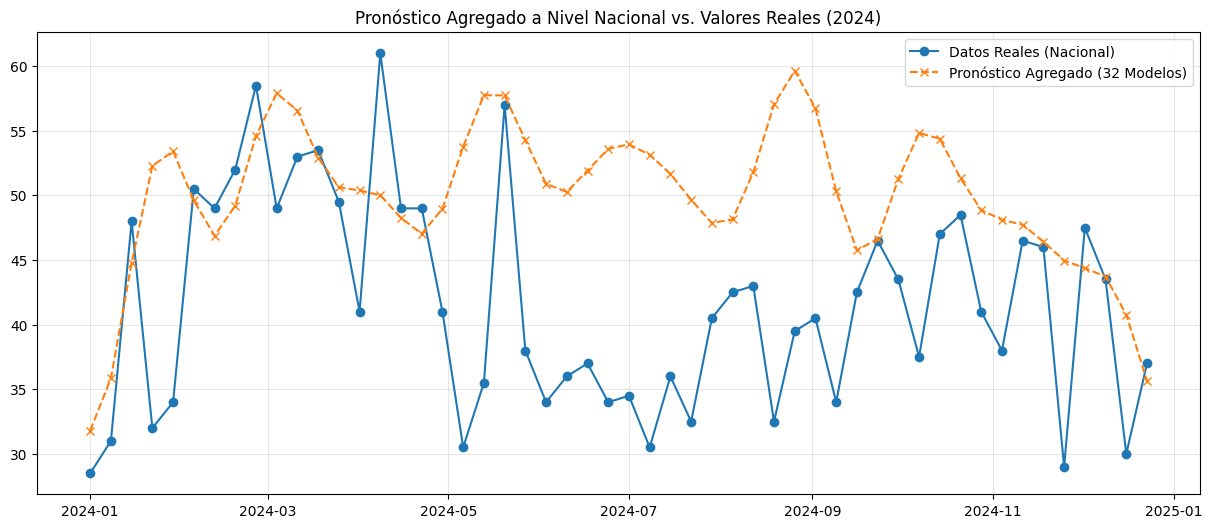

In [49]:
print("\n--- Paso 7: Evaluación a Nivel Nacional (Agregado) ---")

# --- 7.1 Evaluación a Nivel Nacional (Agregado) ---

# Se preparan los datos de PRUEBA (reales) a nivel Nacional
# Se busca la primera fecha del período de prueba para alinear los datos
fecha_inicio_prueba = df_pronosticos_final['ds'].min()

df_test_national = df_eval_national[df_eval_national['Date'] >= fecha_inicio_prueba].copy()
df_test_national = df_test_national.set_index('Date')['New_Cases'] # Se usa 'New_Cases'

# Se agregan las PREDICCIONES (pronósticos) a nivel Nacional
# Se suman las 32 predicciones
df_pred_national = df_pronosticos_final.groupby('ds')['yhat'].sum()

# Se calculan las métricas a nivel Nacional
y_true_national = df_test_national
y_pred_national = df_pred_national

mape_national = mean_absolute_percentage_error(y_true_national, y_pred_national) * 100
rmse_national = np.sqrt(mean_squared_error(y_true_national, y_pred_national))
mae_national = mean_absolute_error(y_true_national, y_pred_national)

print("\n--- Métricas a Nivel NACIONAL (Agregado de 32 Modelos) ---")
print(f"MAPE a Nivel Nacional (Agregado): {mape_national:.2f}%")
print(f"RMSE a Nivel Nacional (Agregado): {rmse_national:.2f}")
print(f"MAE a Nivel Nacional (Agregado):  {mae_national:.2f}")

# --- 7.2 Visualización a Nivel Nacional ---
plt.figure(figsize=(15, 6))
plt.plot(df_test_national.index, df_test_national, 'o-', label='Datos Reales (Nacional)')
plt.plot(df_pred_national.index, df_pred_national, 'x--', label='Pronóstico Agregado (32 Modelos)')
plt.title('Pronóstico Agregado a Nivel Nacional vs. Valores Reales (2024)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


--- Paso 10: Generando Pronóstico Agregado para 2025 ---
Generando pronósticos de 52 semanas para los 32 modelos...


03:04:34 - cmdstanpy - INFO - Chain [1] start processing
03:04:34 - cmdstanpy - INFO - Chain [1] done processing
03:04:35 - cmdstanpy - INFO - Chain [1] start processing
03:04:35 - cmdstanpy - INFO - Chain [1] done processing
03:04:36 - cmdstanpy - INFO - Chain [1] start processing
03:04:36 - cmdstanpy - INFO - Chain [1] done processing
03:04:37 - cmdstanpy - INFO - Chain [1] start processing
03:04:38 - cmdstanpy - INFO - Chain [1] done processing
03:04:39 - cmdstanpy - INFO - Chain [1] start processing
03:04:39 - cmdstanpy - INFO - Chain [1] done processing
03:04:40 - cmdstanpy - INFO - Chain [1] start processing
03:04:40 - cmdstanpy - INFO - Chain [1] done processing
03:04:41 - cmdstanpy - INFO - Chain [1] start processing
03:04:41 - cmdstanpy - INFO - Chain [1] done processing
03:04:42 - cmdstanpy - INFO - Chain [1] start processing
03:04:42 - cmdstanpy - INFO - Chain [1] done processing
03:04:43 - cmdstanpy - INFO - Chain [1] start processing
03:04:43 - cmdstanpy - INFO - Chain [1]

Pronóstico futuro completado para los 32 modelos.

Generando gráfica de pronóstico nacional para 2025...


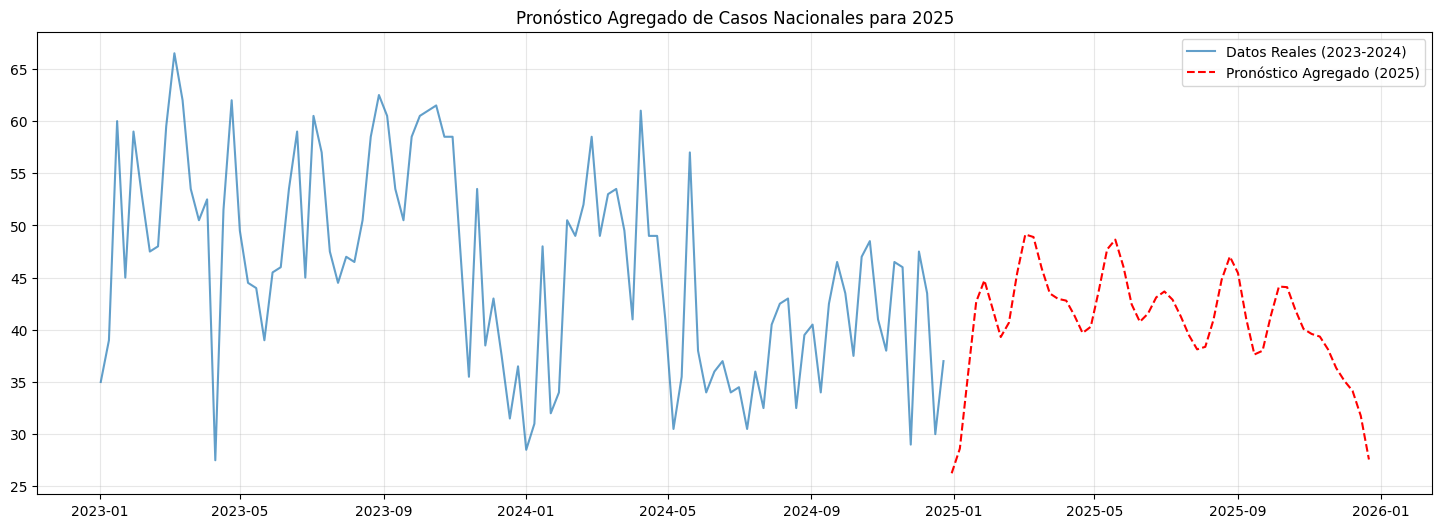

In [51]:
print("\n--- Paso 10: Generando Pronóstico Agregado para 2025 ---")

# 1. Se inicializa una lista para guardar las predicciones FUTURAS
lista_de_pronosticos_futuros = []
HORIZONTE_FUTURO = 52 # 52 semanas para 2025

print("Generando pronósticos de 52 semanas para los 32 modelos...")

# Se itera sobre cada uno de los 32 grupos únicos (entidades)
for i, grupo_id in enumerate(grupos_unicos):
    
    # 2. Se aíslan los datos COMPLETOS (2014-2024) para este estado
    df_serie_full = df_prophet_master[df_prophet_master['unique_id'] == grupo_id]
    
    # 3. Se obtienen los mejores parámetros para este estado (del Paso 5)
    try:
        best_params_grupo = df_tiempos_final[df_tiempos_final['unique_id'] == grupo_id]['best_params'].iloc[0]
    except IndexError:
        print(f"Advertencia: No se encontraron parámetros para {grupo_id}, usando default.")
        best_params_grupo = {} # Usa parámetros por defecto si algo falló
    
    try:
        # 4. Se entrena el modelo final con los mejores parámetros sobre los DATOS COMPLETOS
        modelo_full_fit = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            holidays=pandemia_covid,
            **best_params_grupo
        )
        modelo_full_fit.fit(df_serie_full)
        
        # 5. --- PREDICCIÓN FUTURA (2025) ---
        # Se crea el DataFrame de fechas futuras (52 semanas)
        future_df = modelo_full_fit.make_future_dataframe(
            periods=HORIZONTE_FUTURO, 
            freq='W-MON' # Se asegura la frecuencia semanal
        )
        
        # Se genera el pronóstico
        prediccion_futura = modelo_full_fit.predict(future_df)
        
        # 6. Se guardan ÚNICAMENTE las 52 nuevas predicciones (el 2025)
        pronostico_2025 = prediccion_futura.iloc[-HORIZONTE_FUTURO:][['ds', 'yhat']]
        pronostico_2025['unique_id'] = grupo_id
        lista_de_pronosticos_futuros.append(pronostico_2025)
    
    except Exception as e:
        print(f"Error al procesar el pronóstico de {grupo_id}: {e}")
        continue

print("Pronóstico futuro completado para los 32 modelos.")

# --- 10. Agregación y Visualización del Pronóstico Nacional 2025 ---

# 10a. Se consolidan y agregan las predicciones
df_futuro_final = pd.concat(lista_de_pronosticos_futuros)
df_pronostico_nacional_2025 = df_futuro_final.groupby('ds')['yhat'].sum()

# 10b. Se obtienen los datos REALES nacionales (para dar contexto)
df_real_nacional_full = df_eval_national.set_index('Date')['New_Cases']

# 10c. Se visualiza el pronóstico
print("\nGenerando gráfica de pronóstico nacional para 2025...")
plt.figure(figsize=(18, 6))

# Se grafica el histórico de los últimos 2 años (2023-2024)
plt.plot(
    df_real_nacional_full.loc['2023-01-01':], 
    label='Datos Reales (2023-2024)', 
    alpha=0.7
)
# Se grafica el nuevo pronóstico para 2025
plt.plot(
    df_pronostico_nacional_2025, 
    label='Pronóstico Agregado (2025)', 
    linestyle='--', 
    color='red'
)

plt.title('Pronóstico Agregado de Casos Nacionales para 2025')
plt.legend()
plt.grid(alpha=0.3)
plt.show()